# Chapter 8. Recurrent Neural Networks
- Tabular Data => MLP 
- Image => CNN
- MLP 및 CNN까지는 I.I.D (Independent / Identically Distributed)가정 기본 조건으로 하였음
- 언어 / 비디오 이미지 / 오디오 등 데이터에 대해서는 I.I.D 가정이 성립되지 않음 (앞뒤 맥락을 빼고 중간의 데이터만 가지고는 의미를 알 수 없음)
- Sequence를 입력으로 받을 뿐 아니라 Sequence를 이어 나가는 것을 해야될 수도 있다. (Stock Price Prediction 등)
> CNN는 공간적 정보(Spatial Information)을 처리하는데 효과적이었다면 RNN은 순차적 정보 (Sequential Information)을 더 효과적으로 처리


### Statistical Tools 
- Stock Price 예측의 문제
- 이전의 데이터를 입력으로 다음 값을 예측
  - P(xt | xt-1 ...., x1)

### Autoregressive Models
- What is autoregressive model?
  - 임의의 Sequence를 입력으로 사용하여 같은 Sequence에 포함된 특정 값을 예측하는 것 => auto + regressive
- 이러한 Sequence Model에 Regression을 적용할 경우 문제점
  - 입력의 길이가 예측하고자 하는 시점 t에 따라서 달라짐
  - 따라서 어떻게 이러한 가변 길이 입력을 연산 가능한 형태로 만들것인가에 대한 적절한 방법이 필요
- Sequence Model로 특정 시점의 값 x_t를 예측하는 것은 결국 ```P(x_t | x_t-1,....,x_1)```를 어떻게 효율적으로 구할 것인가에 대한 문제이며 이에 대한 주요 접근 방식 2 가지를 요약하면 아래와 같다.
  - sequence 내에서 예측 대상 이전의 모든 구간을 입력으로 사용하는 대신 예측 대상 이전의 일부 구간만을 입력으로 사용하여 sequence의 임의 값을 예측 (autoregressive model)
  - 이전 값들을 대표하는 state를 두는 것 (latent state)
  - **Latent Autoregressive Model** 


#### Markov Model
- 앞서 언급된 Autoregressive model의 접근 방법(즉, Sequence 내 임의의 값을 예측할 때 임의 값 전체 구간이 아닌 일부 구간을 입력으로 사용)을 통한 예측이 가능하려면 해당 Sequence는 Markov condition을 충족해야 한다.
- 특히, 이 입력의 구간의 크기 T=1인 경우를 first-order markov model이라고 하며 아래와 같이 정의

```
P(x_1, ...,x_T) = product of all element from t=1 ~ t=T ( P(x_t | x_t-1) )
```

- 이러한 first-order markov model은 특히,discrete value의 sequence일 때 dynamic programming을 적용할 수 있는 장점이 있다. 




#### Causality
- 이론적으로 Markov model은 P(x)를 역순으로 전개하는 것이 가능하다.
- 하지만 많은 경우 데이터 자체에 시간적 순차성이 존재
- 이러한 경우 이러한 역순 전개는 유효하지 않다.
- 다행히 우리가 일반적으로 관심을 가지는 것은 순방향 전개이며 (Hoyer 등에 의해) 어떤 조건을 만족하면 ```x_t+1 = f(x_t) + e```를 통해 순방향 전개 예측이 가능함이 이론적으로 밝혀 졌다.

### Training
- 임의 Sequence를 생성
- Sequence를 임의의 구간으로 나누고
- 나뉜 구간에 대한 features와 label pair로 training을 위한 sequence 생성
- 설정된 구간의 길이에 따라 구간 앞의 일부 값의 예측을 위한 입력 feature가 충분치 않은데.
  - 잘라서 버리거나 (예시의 경우)
  - 상수로 padding하거나 

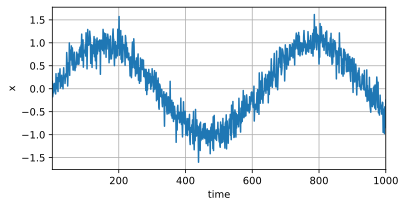

In [2]:
%matplotlib inline
import torch 
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0,0.2, (T, ))
d2l.plot(time, [x], 'time', 'x', xlim=[1,1000], figsize=(6,3))

In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:,i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1,1))


In [4]:
batch_size, n_train = 16, 600

train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [5]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                       nn.ReLU(),
                       nn.Linear(10,1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(),lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, loss : {d2l.evaluate_loss(net,train_iter,loss)}')
net = get_net()
train(net,train_iter, loss, 5, 0.01)

epoch 1, loss : 0.07576845573882261
epoch 2, loss : 0.05265998338659605
epoch 3, loss : 0.05118697941303253
epoch 4, loss : 0.05059129372239113
epoch 5, loss : 0.050277354071537654


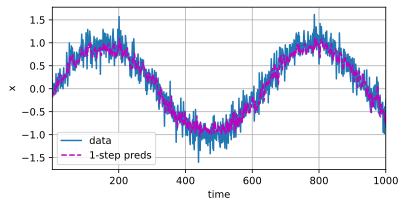

In [6]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]], [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x', 
         legend=['data', '1-step preds'], xlim=[1,1000], figsize=(6,3))

- 위 예시의 one-step-ahead 예측 (즉, 입력 데이터 구간의 바로 뒤의 값을 예측하는 것)은 train 구간 이후에 대해서도 좋은 성능을 보여줌.

##### K-step-ahead prediction  

- 만약 train 구간 이후 입력 데이터가 존재하지 않는다면...?
- train 구간의 마지막으로 부터 one step 씩 window를 shift해가면서 존재하지 않는 구간의 데이터를 생성할 수 있을 것이다.
- 이처럼 입력 데이터로 부터 시간적 거리(k)가 있는 값을 예측하는 것을 => **k-step-ahead prediction**이라 함.


In [7]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

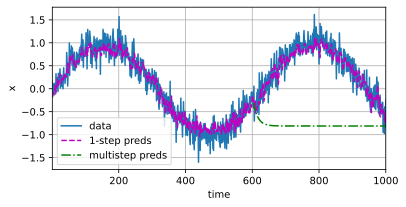

In [8]:
d2l.plot([time, time[tau:], time[n_train + tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy(),
         multistep_preds[n_train + tau:].detach().numpy()], 'time',
        'x', legend=['data', '1-step preds', 'multistep preds'], xlim=[1,1000], figsize=(6,3))

- 위 예시에서 k-step-ahead prediction의 k가 커지면서 예측 오차가 함께 점점 커짐.
- error의 누적
  - 이는 예측 step이 증가 할 수록 예측의 error가 증가하기 때문이다. (예측이 다시 다음 값의 입력이 되므로...)
- 다음과 같이 k를 0 ~ 64까지 변화시켜보면 이러한 경향을 더욱 뚜렷하게 확인할 수 있음

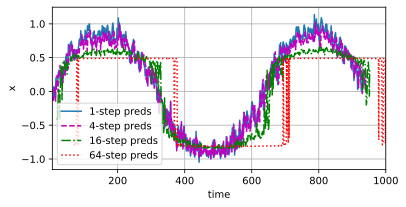

In [9]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))

for i in range(tau):
    features[:,i] = x[i: i + T - tau - max_steps + 1]

    
for i in range(tau, tau + max_steps):
    features[:,i] = net(features[:, i - tau:i]).reshape(-1)
    
steps = (1, 4, 16, 64)

d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000], 
        figsize=(6,3))




## Text Preprocessing
- Text 데이터에 Nueral Network를 적용하기 위해 앞의 예시의 데이터 처럼 Numerical Form으로 변환이 필요 
- Steps
  - Text를 string 데이터로 메모리에 적재
  - Token으로 분할
  - 분할 된 Token을 numerical index를 할당하여 vocabulary table을 생성
  - text를 위 table의 indices의 sequence로 변환 

### Reading the dataset 
- The Time Machine by H. G. Wells 텍스트 데이터를 사용

In [10]:
import collections
import re
from d2l import torch as d2l

#@save 
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt', 
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine(): #@save
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# test lines : {len(lines)}')
print(lines[0])
print(lines[10])
    

# test lines : 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


### Tokenization
- 보통 Text 데이터를 읽어오면 list of lines 형태로 적재됨.
- text를 일종의 기본 단위 (basic unit)을 쪼갬. 
- list of lines => list of tokens


In [11]:
def tokenize(lines, token='word'): #@save
    if token == 'word':
        return [line.split() for line in lines]
    if token == 'char':
        return [list(line) for line in lines]
    
tokens = tokenize(lines)
for i in range(10):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']


### Vocabulary
- text의 기본 단위인 token을 numerical representaion으로 변환하기 위해 구축된 dictionary
- 이러한 dictionary를 생성하기 위해
  
  1. corpus에서 unique token을 count
  2. 각 고유한 token을 corpus 내 frequency에 따라 numerical index를 할당 (매우 낮은 빈도의 token은 복잡도를 낮추기 위해 제거되기도 함)
- 주요 Special Token

  - ```UNK``` :  dictionary에 없는 token
  - ```PAD``` :  padding
  - ```BOS``` :  begining of sentence
  - ```EOS``` :  end of sentence
  
  


In [12]:
class Vocab:  #@save
    
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], 
                                   reverse=True)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
                
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs
    
    
def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)


        

In [13]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [14]:
for i in [0,10]:
    print(f'words: {tokens[i]}')
    print(f'indices : {vocab[tokens[i]]}')

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices : [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices : [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [15]:
def load_corpus_time_machine(max_tokens=-1): #@save
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)
    

(170580, 28)

## Language Models and the dataset

- Language Model의 목적은 다수의 token들로 구성된 sequence의 joint probability를 예측하는 것으로 볼 수 있으며 이를 위해서는 아래와 같은 정보가 필요함
  - 개별 Token(단어)의 확률 (빈도) 정보
    
    ```=> 전체 단어 갯수로 대상 단어의 갯수를 나눔으로써...```
    
  - Sequence 내의 각 Token(단어)에 선행하는 Token(단어)에 대한 조건부 확률 정보
    
    ```=> token pair의 조합 Occurence를 선행 token의 occurence로 나눔으로써...```
  
 > P(x_2|x_1) = n(x_2, x_1) / n(x_1)   

- 문제점 
  - 어떤 단어의 조합이 문법적으로 가능한 표현임에도 데이터내에 매우 낮은 빈도를 갖을 수 있음
  - 이러한 조합 빈도의 문제는 조합의 길이가 길어질 수록 심각해짐

#### Laplace smoothing
- 매우 작은 상수를 모든 token의 occurence에 추가함으로써 데이터의 low frequency pattern의 정보의 유실을 방지
- 문제점 
  - bad scalibility 
    - 모든 token 및 token 조합의 빈도를 기록하고 있어야함. (매번 count할 것이 아니라면...)
  
  - token이 갖는 의미의 유사성을 반영하지 못함
  
  - long token sequence와 같이 학습 데이터내 아예 존재하지 않는 경우에 대하여 성능 저하 발생
 


### Markov Models and n-grams
- 만약 P(x_t+1|x_t, ...,x_1) = P(x_t+1|x_t)일 경우 first order Markov property를 만족한다.
- higher order markov property의 경우 더 긴 의존성을 의미한다. 
- 이와 같이 Markov Property를 만족하는 확률 분포를 갖는 sequence를 Order에 따라 unigram, bigram, trigram, ....n-gram으로 부른다. 

### Natural Languages Statistics


[('the', 2261), ('i', 1267), ('and', 1245), ('of', 1155), ('a', 816), ('to', 695), ('was', 552), ('in', 541), ('that', 443), ('my', 440)]


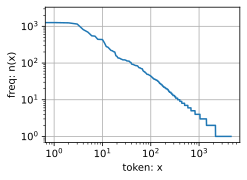

In [16]:
import random
import torch 
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())

corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
print(vocab.token_freqs[:10])

freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='freq: n(x)', xscale='log', yscale='log')



- 높은 빈도를 갖는 word들 대부분 매우 지루한 단어들이며 이러한 것들을 **stop word**라고 하여 종종 filter out 해버리기도 한다. 
- 10번째로 자주 등장하는 token이 제일 많이 등장하는 token의 1/5밖에 안된다.
- 빈도의 감소가 매우 급격하게 (지수) 발생됨
- Word Freq. Decay는 잘 정의된 Decay 경향을 갖는데,
- Zipf's law 만족

> Zipf's law는 어떤 Quantity와 해당 Quantity의 Rank가 반비례 관계를 갖는 것. log-log scale에서 straight  line


In [17]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [18]:
trigram_tokens = [tri for tri in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

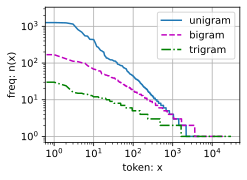

In [19]:
bigram_freqs = [freq for _,freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for _,freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], 
         xlabel='token: x', ylabel='freq: n(x)', 
         xscale='log', yscale='log', legend=['unigram', 'bigram', 'trigram'])

### N-grams frequency

- unigram ~ trigram까지 비록 decay 정도는 줄어 들지만 Zipf's law를 따름
- n-gram의 개별 count는 크지 않다.
- 많은 n-gram들의 빈도가 매우 낮다. (unigram 대비) => Laplace smoothing이 소용없다.

### Reading Long Sequence Data
- Nueral Network는 predefine 된 고정 입력 size를 가지고 있음
- 동일한 size의 입력으로 데이터를 나누더라도 offset에 따라 매우 많은 경우가 존재함
- 데이터의 coverage를 극대화하는 측면에서 모든 경우를 하는 것이 이상적 => 비현실적
- Random sampling을 통해 coverage와 computation의 현실성을 절충

  - Random Sampling
  - Sequential Partitioning 


#### Random Sampling
- 각 batch는 임의로 추출된다.
- 두 인접한 subsequence는 반드시 인접할 필요 없고..
- language model의 목표는 지금까지 입려된 sequence를 기반으로 next token을 맞추는 것이므로 Labels은 원래 sequence를 token 한개 만큼 shift한것이면 됨.


  


In [20]:
def seq_data_iter_random(corpus, batch_size, num_steps): #@save
    corpus = corpus[random.randint(0, num_steps - 1):]  ## give random offset
    num_subseqs = (len(corpus) - 1) // num_steps        
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    random.shuffle(initial_indices)  ## randomize possible indices for initial pos. 
    
    def data(pos):
        return corpus[pos: pos + num_steps]
    
    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        initial_indices_per_batch = initial_indices[i:i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)


In [21]:
my_seq = list(range(35))
for X,Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print(f'X: {X},\n Y: {Y}')


X: tensor([[25, 26, 27, 28, 29],
        [10, 11, 12, 13, 14]]),
 Y: tensor([[26, 27, 28, 29, 30],
        [11, 12, 13, 14, 15]])
X: tensor([[20, 21, 22, 23, 24],
        [ 0,  1,  2,  3,  4]]),
 Y: tensor([[21, 22, 23, 24, 25],
        [ 1,  2,  3,  4,  5]])
X: tensor([[15, 16, 17, 18, 19],
        [ 5,  6,  7,  8,  9]]),
 Y: tensor([[16, 17, 18, 19, 20],
        [ 6,  7,  8,  9, 10]])


#### Sequential Partitioning
- Random Sampling의 경우 batch간에 순차성만 추가한 Version 


In [22]:
def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size ## number of tokens for each batch 
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i:i + num_steps]
        Y = Ys[:, i:i + num_steps]
        yield X,Y
    
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print(f'X: {X}\nY: {Y}')

X: tensor([[ 3,  4,  5,  6,  7],
        [18, 19, 20, 21, 22]])
Y: tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]])
X: tensor([[ 8,  9, 10, 11, 12],
        [23, 24, 25, 26, 27]])
Y: tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]])
X: tensor([[13, 14, 15, 16, 17],
        [28, 29, 30, 31, 32]])
Y: tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]])


In [23]:
class SeqDataloader: #@save
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)
    
def load_data_time_machine(batch_size, num_steps, use_random_iter=False, max_tokens=10000): #@save
    data_iter = SeqDataloader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

## Recurrent Nueral Network
- Language Modeling을 위한 다양한 시도들 
  - n-gram MLP Model 
    - 1-step-ahead 일 경우 큰 문제 없으나
    - k-step ahead에 대해 error에 취약
  - n-gram 모델에서 n이 증가 할 수록 frequency가 매우 낮아지게 되며 (Zipf's law) 
  - long sequence에 대한 적절한 확률 모델 정보를 얻기가 매우 어려움
  - n을 고정하거나 단순히 증가하는 방식만으로는 적절한 language model을 구축하는데 한계가 있음

- Latent Variable Model 

  - 이전 입력에 따른 상태, hidden state를 갖는 Model
``` 
P(x_t | x_t-1, ...., x_1) = P(x_t | h_t-1) 
```
  
  - hidden state는 현재 입력과 이전 hidden state의 함수 즉,
```
h_t = f(x_t, h_t-1)
```
  
  - 참고. 앞서 MLP에서 언급했던 hidden layer 및 hidden unit 과는 완전히 다른 개념임
  
  
### Recurrent Nueral Network with hidden states
- 임의 시점 t의  hidden state ```h_t```는 입력 ```x_t``` 그리고 ```h_t-1```의 함수로써 아래와 같이 표현될 수 있다. 

```
H_t = activation(matmul(X_t, W_xh) + matmul(H_t-1, W_hh) + b_h)
```
- 위와 같이 Hidden state가 다시 hidden state에 의존성을 갖기 떄문에 recurrent neural network라고 부르는 것. 
- 위의 예시는 단순화된 경우일 뿐, Recurrent hidden state의 실제 구현 방법은 여러가지가 있다.
- 위 예시의 hidden state 계산에서 matmul(x_t, W_xh) + matmul(H_t-1, W_hh)는 등가적으로 matmul(concat(x_t,h_t-1), concat(w_xh, w_hh))로 변환 할 수 있다. 
  - matmul 2번 => matmul 1번


### RNN-based Character-level language models
- cross entropy loss for each step
- each token d-dim. vector (one hot?)
- batch가 n이면 1 step의 입력은 n x d matrix

### Perplexity

- measuring the quality of language model
- 예측된 sequence의 자연스러움
- likelyhood of sequence를 계산 
- 문제는 n-gram 실험에서 확인한 것과 같이 shorter sequence의 likelyhood가 높게 나온다는 것. 
  - 뭔가 모든 경우를 다고려 할 수 있는 Average 같은 것이 필요
- **모든 token에 대한 cross entropy loss의 평균**을 구함으로써 이러한 문제를 해소할 수 있음 (based on information theory)
- exp( averaged cross entropy loss)

#### Perflexity by case
- Ideal case (perflexity = 1)
```
이상적으로 모든 예측이 완벽하면 perplexity 값은 1로 수렴
```

- worst case  (perflexity = pos. infinite)
```
(다 틀리는 경우) positive infinite으로 수렴
```

- baseline (perflexity = # of unique token)
```
모든 token에 대해 uniform distribution의 prediction을 한다면 perflexity는 unique token의 갯수와 같아짐. model이 기본적으로 충족해야 하는 upper bound로써의 의미 
```

## Implementaion of RNN from Scratch



In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32,35 
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### One-Hot Encoding

- 각 token을 서로 직교하는 unit vector로 표현
- 만약 고유한 token의 갯수가 N이면 이러한 unit vector의 shape은 (1, N)

### Initializing model parameters

In [2]:
def get_params(vocab_size, num_hiddens, device):
    
    num_inputs = num_outputs = vocab_size 
    
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    
    for param in params:
        param.requires_grad_(True)
    return params

### RNN Model
#### initialize hidden state 
- tuple 형태로 return함, 이는 multiple variable을 포함할 경우를 위한 고려




In [3]:
def init_rnn_state(batch_size, num_hiddens, device):
    ## NOTE: the state is returned as tuple type
    return (torch.zeros((batch_size, num_hiddens), device=device),)  

#### RNN function
- input의 형태 (step, batch, token vector)

In [4]:
def rnn(inputs, state, params):
    W_xh, W_hh, b_h , W_hq, b_q = params
    H, = state 
    outputs = []
    
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q 
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [5]:
class RNNModelScratch:
    
    def __init__(self, vocab_size, num_hiddens, device, 
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
        
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)
        

- output 및 state 등 shape check (input output shape이 똑같아야 되고...hidden state는 shape이 유지되어야 하고...)

In [6]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape



NameError: name 'X' is not defined